In [79]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt


### Creating a one bus for the Netherlands

In [80]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)


network.add("Bus", "electricity bus", carrier="electricity")
network.add("Carrier", "electricity")  

network.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

#### Getting the demand for the Netherlands and adding it to the bus

In [81]:
# Define file path
file_path = "Data/electricity_demand.csv"

# Load dataset
data = pd.read_csv(file_path, sep=';', parse_dates=['utc_time'], index_col='utc_time')
data.index = pd.to_datetime(data.index, utc=True)
# Convert index to datetime format
data.index = pd.to_datetime(data.index, utc=True)

start_date = '2015-01-01 00:00:00+00:00'
end_date = '2015-12-31 23:00:00+00:00'

data = data[start_date:end_date]
country = 'NLD'
data = data[country]
print(data.head())

utc_time
2015-01-01 00:00:00+00:00    11338.0
2015-01-01 01:00:00+00:00    10917.0
2015-01-01 02:00:00+00:00    10473.0
2015-01-01 03:00:00+00:00    10200.0
2015-01-01 04:00:00+00:00    10182.0
Name: NLD, dtype: float64


In [82]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set = data.values)

Index(['load'], dtype='object')

In [83]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,11338.0
2015-01-01 01:00:00,10917.0
2015-01-01 02:00:00,10473.0
2015-01-01 03:00:00,10200.0
2015-01-01 04:00:00,10182.0
...,...
2015-12-31 19:00:00,12958.0
2015-12-31 20:00:00,12263.0
2015-12-31 21:00:00,11772.0


#### Adding different generation types 

In [84]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
print(annuity(25,0.07))
print(annuity(25,0.07)*425000*(1+0.03))

0.0858105172206656
37563.55391334636


In [85]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "coal", co2_emissions=0.363) # in /MWh_tt_CO2h
network.add("Carrier", "offshorewind")
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "nuclear")
network.add("Carrier", "gas", co2_emissions=0.22) # in /MWh_tt_CO2h



# add onshore wind generator
df_onshorewind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind_on = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*1088000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_on.values)

# add offshore wind generator
df_offshorewind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
CF_wind_off = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshorewind = annuity(30,0.07)*2084520*(1+0.033) # in €/MW
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=7000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off.values)

# add solar PV generator
df_solar = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*600290*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add Gas CC W/o ccts
capital_cost_CCGT = annuity(30,0.07)*1300000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.58 # MWh_elec/MWh_th
VOM_gas = 4 # in €/MWh
marginal_cost_CCGT = VOM_gas + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=7000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)


# add coal power plant  generator coal IGCC W/o ccts
capital_cost_coal = annuity(40,0.07)*3088000*(1+0.03) # in €/MW
fuel_cost = 8.4 # in €/MWh_th
efficiency = 0.392 # MWh_elec/MWh_th
VOM_coal = 6 # in €/MWh
marginal_cost_coal = VOM_coal + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=7000,
            capital_cost = capital_cost_coal,
            marginal_cost = marginal_cost_coal)


# add nuclear power plant generator
capital_cost_nuclear = annuity(45,0.07)*8594000*(1+0.027) # in €/MW
fuel_cost = 3 # in €/MWh_th 
efficiency = 0.33 # MWh_elec/MWh_th
VOM_nuclear = 10 # in €/MWh
marginal_cost_nuclear = VOM_nuclear + fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=7000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

Index(['nuclear'], dtype='object')

In [86]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2015-01-01 00:00:00,0.734,0.360,0.0
2015-01-01 01:00:00,0.758,0.383,0.0
2015-01-01 02:00:00,0.787,0.417,0.0
2015-01-01 03:00:00,0.794,0.432,0.0
2015-01-01 04:00:00,0.802,0.443,0.0
...,...,...,...
2015-12-31 19:00:00,0.798,0.448,0.0
2015-12-31 20:00:00,0.798,0.465,0.0
2015-12-31 21:00:00,0.794,0.451,0.0


In [87]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]
INFO:linopy.io: Writing time: 1.35s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-mqxvefy2.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-mqxvefy2.lp


Reading time = 0.30 seconds


INFO:gurobipy:Reading time = 0.30 seconds


obj: 113886 rows, 52566 columns, 205855 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 205855 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 205855 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 205855 nonzeros


Model fingerprint: 0x3c640133


INFO:gurobipy:Model fingerprint: 0x3c640133


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [2e+01, 6e+05]


INFO:gurobipy:  Objective range  [2e+01, 6e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e+03, 2e+04]


INFO:gurobipy:  RHS range        [9e+03, 2e+04]


Presolve removed 56957 rows and 4391 columns


INFO:gurobipy:Presolve removed 56957 rows and 4391 columns


Presolve time: 0.17s


INFO:gurobipy:Presolve time: 0.17s


Presolved: 56929 rows, 48175 columns, 144507 nonzeros


INFO:gurobipy:Presolved: 56929 rows, 48175 columns, 144507 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 9.634e+04


INFO:gurobipy: AA' NZ     : 9.634e+04


 Factor NZ  : 5.298e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 5.298e+05 (roughly 50 MB of memory)


 Factor Ops : 5.161e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.161e+06 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.12042615e+10  0.00000000e+00  1.21e+05 0.00e+00  3.47e+07     0s


INFO:gurobipy:   0   7.12042615e+10  0.00000000e+00  1.21e+05 0.00e+00  3.47e+07     0s


   1   9.82768411e+10 -1.37686853e+11  1.87e+04 3.77e+02  8.34e+06     0s


INFO:gurobipy:   1   9.82768411e+10 -1.37686853e+11  1.87e+04 3.77e+02  8.34e+06     0s


   2   7.45988782e+10 -6.18488891e+10  2.18e-11 3.00e-09  9.44e+05     1s


INFO:gurobipy:   2   7.45988782e+10 -6.18488891e+10  2.18e-11 3.00e-09  9.44e+05     1s


   3   2.09518986e+10 -1.31506479e+09  1.46e-10 9.44e-10  1.54e+05     1s


INFO:gurobipy:   3   2.09518986e+10 -1.31506479e+09  1.46e-10 9.44e-10  1.54e+05     1s


   4   1.51822513e+10  1.87934294e+09  1.60e-10 1.75e-09  9.21e+04     1s


INFO:gurobipy:   4   1.51822513e+10  1.87934294e+09  1.60e-10 1.75e-09  9.21e+04     1s


   5   1.29971349e+10  3.39551298e+09  6.69e-10 1.37e-09  6.64e+04     1s


INFO:gurobipy:   5   1.29971349e+10  3.39551298e+09  6.69e-10 1.37e-09  6.64e+04     1s


   6   1.27064316e+10  3.65177951e+09  1.05e-09 1.07e-09  6.27e+04     1s


INFO:gurobipy:   6   1.27064316e+10  3.65177951e+09  1.05e-09 1.07e-09  6.27e+04     1s


   7   1.21656371e+10  4.38062951e+09  2.84e-09 1.32e-09  5.39e+04     1s


INFO:gurobipy:   7   1.21656371e+10  4.38062951e+09  2.84e-09 1.32e-09  5.39e+04     1s


   8   9.55544032e+09  5.63402811e+09  7.64e-08 1.13e-09  2.71e+04     1s


INFO:gurobipy:   8   9.55544032e+09  5.63402811e+09  7.64e-08 1.13e-09  2.71e+04     1s


   9   8.43698953e+09  6.15454091e+09  8.12e-08 1.06e-09  1.58e+04     1s


INFO:gurobipy:   9   8.43698953e+09  6.15454091e+09  8.12e-08 1.06e-09  1.58e+04     1s


  10   7.77650521e+09  6.31018857e+09  4.43e-08 1.40e-09  1.01e+04     1s


INFO:gurobipy:  10   7.77650521e+09  6.31018857e+09  4.43e-08 1.40e-09  1.01e+04     1s


  11   7.43422727e+09  6.39164970e+09  1.09e-07 1.14e-09  7.21e+03     1s


INFO:gurobipy:  11   7.43422727e+09  6.39164970e+09  1.09e-07 1.14e-09  7.21e+03     1s


  12   7.26028262e+09  6.44387350e+09  1.63e-07 1.81e-09  5.65e+03     1s


INFO:gurobipy:  12   7.26028262e+09  6.44387350e+09  1.63e-07 1.81e-09  5.65e+03     1s


  13   7.16081364e+09  6.50334073e+09  2.49e-07 4.95e-10  4.55e+03     1s


INFO:gurobipy:  13   7.16081364e+09  6.50334073e+09  2.49e-07 4.95e-10  4.55e+03     1s


  14   6.99223976e+09  6.52673635e+09  2.01e-07 7.19e-10  3.22e+03     1s


INFO:gurobipy:  14   6.99223976e+09  6.52673635e+09  2.01e-07 7.19e-10  3.22e+03     1s


  15   6.91737560e+09  6.54335248e+09  6.96e-08 8.40e-10  2.59e+03     1s


INFO:gurobipy:  15   6.91737560e+09  6.54335248e+09  6.96e-08 8.40e-10  2.59e+03     1s


  16   6.87199549e+09  6.54851468e+09  2.08e-08 7.02e-10  2.24e+03     1s


INFO:gurobipy:  16   6.87199549e+09  6.54851468e+09  2.08e-08 7.02e-10  2.24e+03     1s


  17   6.69489483e+09  6.55876395e+09  6.00e-07 2.77e-09  9.42e+02     1s


INFO:gurobipy:  17   6.69489483e+09  6.55876395e+09  6.00e-07 2.77e-09  9.42e+02     1s


  18   6.60756552e+09  6.56920000e+09  5.07e-07 3.96e-09  2.65e+02     1s


INFO:gurobipy:  18   6.60756552e+09  6.56920000e+09  5.07e-07 3.96e-09  2.65e+02     1s


  19   6.60299742e+09  6.56992570e+09  4.43e-07 1.48e-09  2.29e+02     1s


INFO:gurobipy:  19   6.60299742e+09  6.56992570e+09  4.43e-07 1.48e-09  2.29e+02     1s


  20   6.59815285e+09  6.57054180e+09  3.76e-07 5.46e-10  1.91e+02     1s


INFO:gurobipy:  20   6.59815285e+09  6.57054180e+09  3.76e-07 5.46e-10  1.91e+02     1s


  21   6.59334277e+09  6.57311426e+09  2.85e-07 2.77e-10  1.40e+02     1s


INFO:gurobipy:  21   6.59334277e+09  6.57311426e+09  2.85e-07 2.77e-10  1.40e+02     1s


  22   6.57835370e+09  6.57352664e+09  6.57e-08 2.42e-09  3.34e+01     1s


INFO:gurobipy:  22   6.57835370e+09  6.57352664e+09  6.57e-08 2.42e-09  3.34e+01     1s


  23   6.57570711e+09  6.57369584e+09  2.75e-08 7.79e-10  1.39e+01     1s


INFO:gurobipy:  23   6.57570711e+09  6.57369584e+09  2.75e-08 7.79e-10  1.39e+01     1s


INFO:gurobipy:


Barrier performed 23 iterations in 1.45 seconds (0.57 work units)


INFO:gurobipy:Barrier performed 23 iterations in 1.45 seconds (0.57 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   39611    6.5737120e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   39611    6.5737120e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 39611 iterations and 1.54 seconds (0.98 work units)


INFO:gurobipy:Solved in 39611 iterations and 1.54 seconds (0.98 work units)


Optimal objective  6.573712049e+09


INFO:gurobipy:Optimal objective  6.573712049e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 6.57e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [88]:
print(network.objective/1000000) #in 10^6 €

6573.712049064885


In [89]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    58.046086
dtype: float64


In [90]:
network.generators.p_nom_opt # in MW

Generator
onshorewind      1083.333333
offshorewind        0.000000
solar               0.000000
CCGT            17545.250000
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

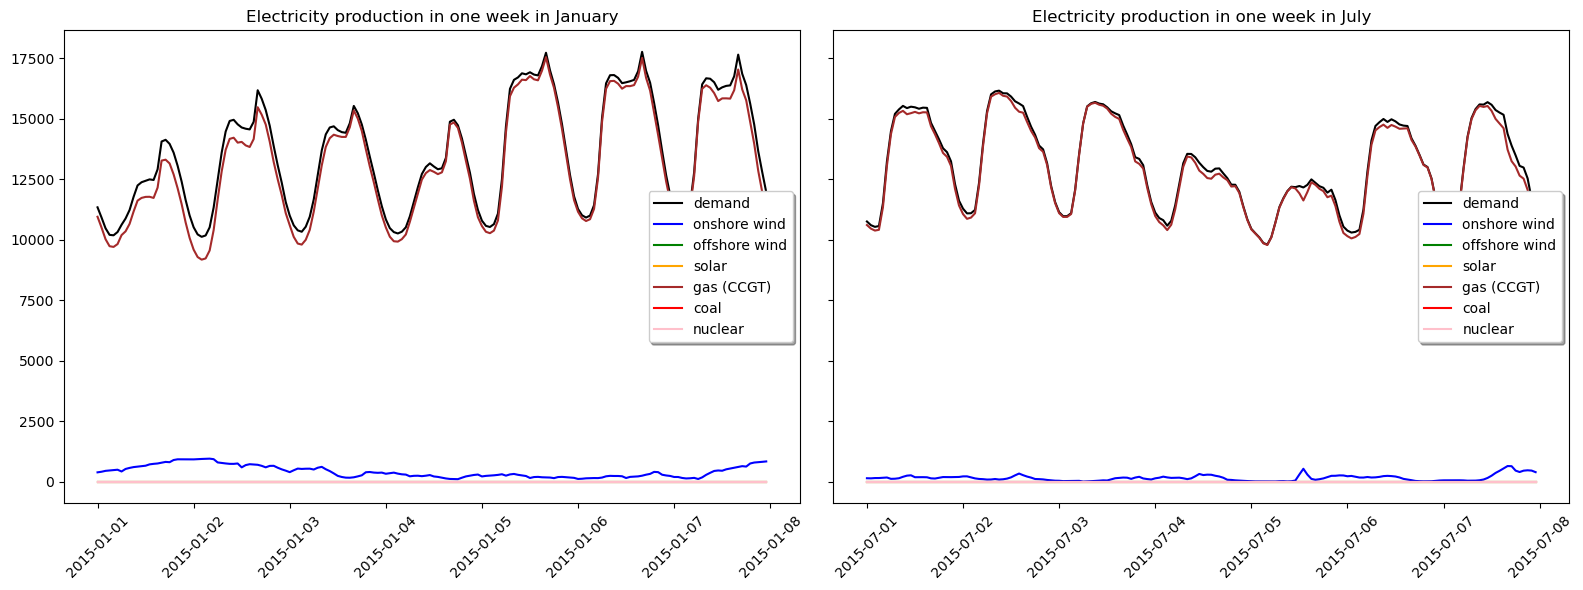

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Electricity mix

Text(0.5, 1.07, 'Electricity mix')

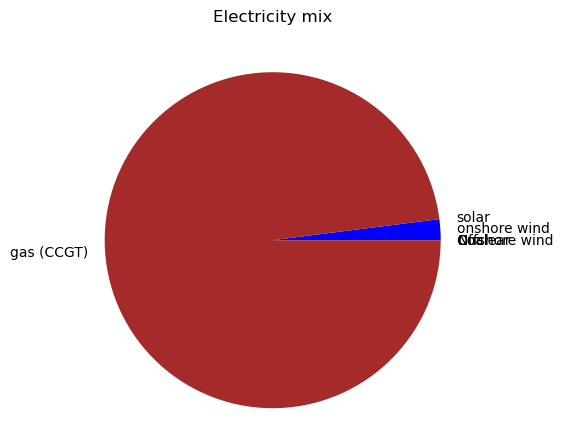

In [92]:
labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [93]:
# Group dispatch by carrier manually
dispatch = network.generators_t.p
carrier_map = network.generators.carrier

# Match generator names to carriers
dispatch.columns = carrier_map[dispatch.columns].values

C:\Users\Change\AppData\Local\Temp\ipykernel_33012\1457957073.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



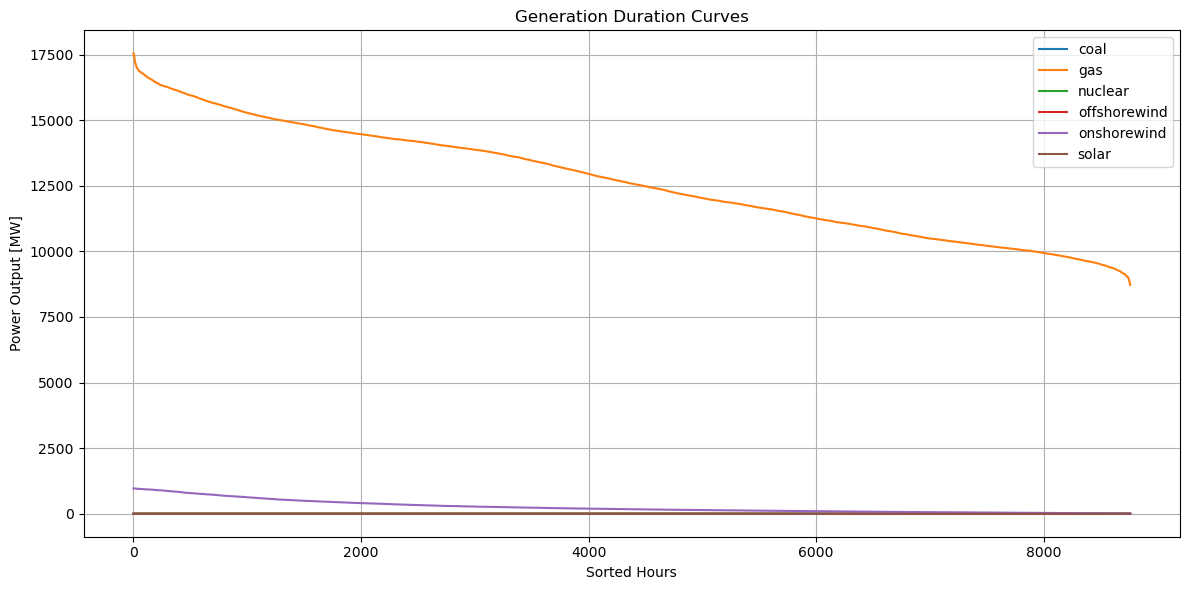

In [94]:
# Sum all generators by carrier
carrier_dispatch = dispatch.groupby(axis=1, level=0).sum()
# Duration curves
carrier_dispatch.apply(lambda x: x.sort_values(ascending=False).reset_index(drop=True)).plot(
    figsize=(12, 6), title="Generation Duration Curves")
plt.ylabel("Power Output [MW]")
plt.xlabel("Sorted Hours")
plt.grid(True)
plt.tight_layout()
plt.show()

## CO2 limit 

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
INFO:linopy.io: Writing time: 1.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-6km937rh.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-6km937rh.lp


Reading time = 0.32 seconds


INFO:gurobipy:Reading time = 0.32 seconds


obj: 113887 rows, 52566 columns, 223375 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 223375 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.92e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Generator
onshorewind     20301.695437
offshorewind        0.000000
solar           14475.825252
CCGT            17372.284741
coal                0.000000
nuclear             0.000000
Name: p_nom_opt, dtype: float64

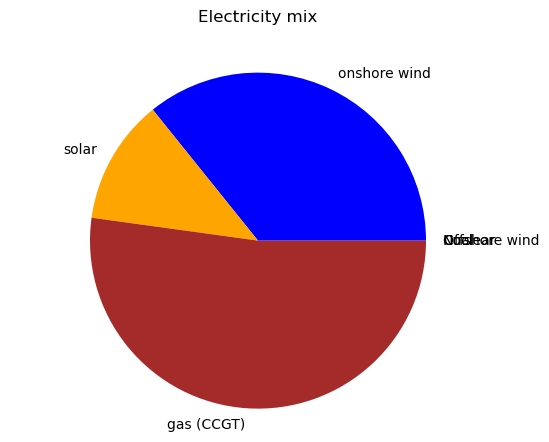

In [95]:
co2_limit=13000000#tonCO2
network.add("GlobalConstraint",
            "co2_limit_13MT",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

#network.optimize(solver_name='gurobi')
network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})



labels = ['onshore wind',
          'solar',
          'gas (CCGT)',
          'Offshore wind',
          'Coal',
          'Nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum(),
        network.generators_t.p['nuclear'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'red', 'pink']    

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

network.generators.p_nom_opt # in MW



In [96]:
print(network.objective/1000000) #in 10^6 €

6923.799911090639


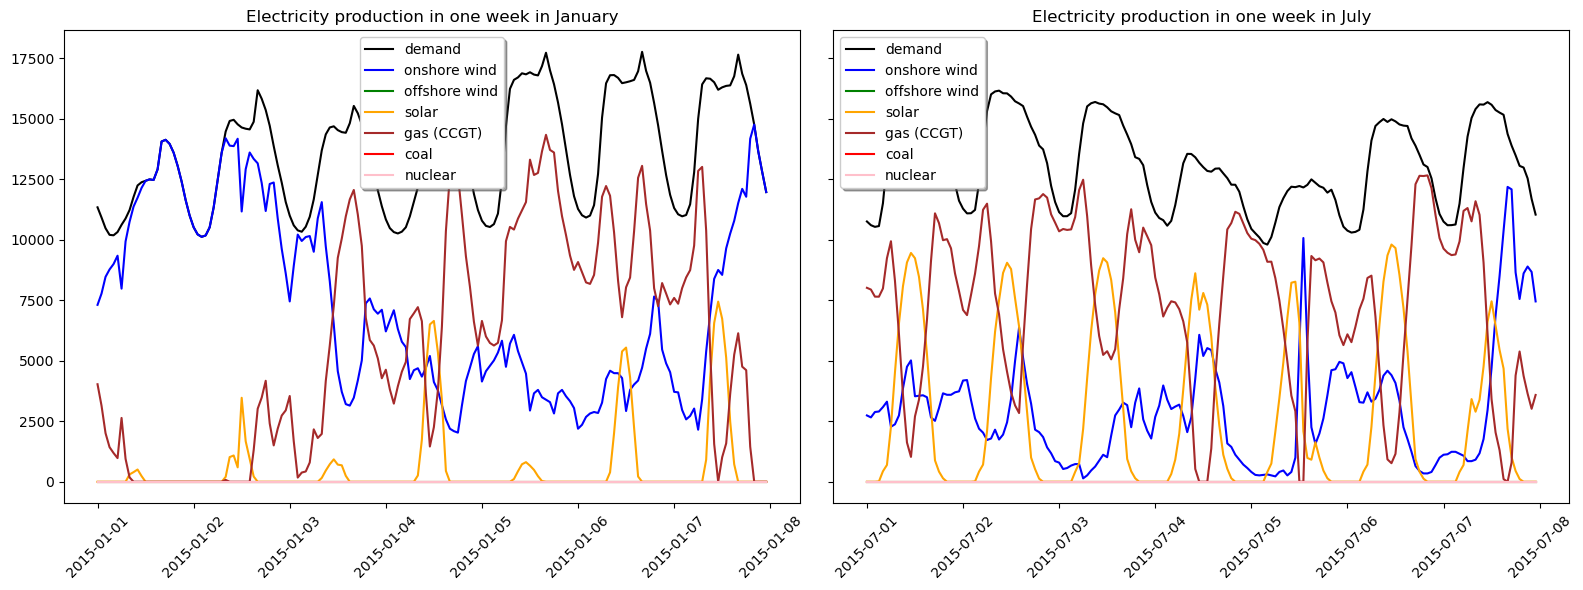

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Part D. Adding Storage Technology

In [129]:
network.add("Carrier", "battery", overwrite = True)
network.add("Carrier", "pumped hydro", overwrite = True)

# add storage units (battery and pumped hydro)
network.add("StorageUnit", "battery", 
            bus="electricity bus",
            p_nom_max = 300,
            max_hours=2,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=0, # in €/MW
            marginal_cost=0,
            carrier="battery",
            overwrite = True,
            cyclic_state_of_charge=True)

network.add("StorageUnit", "pumped_hydro",
            bus="electricity bus",
            p_nom_max = 500,
            max_hours=6,
            p_nom_extendable = True,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost= 0, # in €/MW
            marginal_cost=0,
            carrier="pumped hydro",
            overwrite = True,
            cyclic_state_of_charge=True)

Index(['pumped_hydro'], dtype='object')

In [130]:
network.storage_units.head(3)

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
battery,electricity bus,PQ,,0.0,0.0,True,0.0,300.0,-1.0,1.0,...,False,NaN,True,True,2.0,0.9,0.9,0.0,0.0,0.0
pumped_hydro,electricity bus,PQ,,0.0,0.0,True,0.0,500.0,-1.0,1.0,...,False,NaN,True,True,6.0,0.9,0.9,0.0,0.0,0.0


In [131]:
network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]
INFO:linopy.io: Writing time: 6.91s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2642337


INFO:gurobipy:Set parameter LicenseID to value 2642337


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-gf9fowqo.lp


INFO:gurobipy:Read LP format model from file C:\Users\Change\AppData\Local\Temp\linopy-problem-gf9fowqo.lp


Reading time = 1.59 seconds


INFO:gurobipy:Reading time = 1.59 seconds


obj: 236531 rows, 105128 columns, 486179 nonzeros


INFO:gurobipy:obj: 236531 rows, 105128 columns, 486179 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 236531 rows, 105128 columns and 486179 nonzeros


INFO:gurobipy:Optimize a model with 236531 rows, 105128 columns and 486179 nonzeros


Model fingerprint: 0x6036fed7


INFO:gurobipy:Model fingerprint: 0x6036fed7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 6e+00]


INFO:gurobipy:  Matrix range     [1e-03, 6e+00]


  Objective range  [2e+01, 6e+05]


INFO:gurobipy:  Objective range  [2e+01, 6e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+02, 1e+07]


INFO:gurobipy:  RHS range        [3e+02, 1e+07]


Presolve removed 162081 rows and 4393 columns


INFO:gurobipy:Presolve removed 162081 rows and 4393 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 74450 rows, 100735 columns, 267147 nonzeros


INFO:gurobipy:Presolved: 74450 rows, 100735 columns, 267147 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.10s


INFO:gurobipy:Ordering time: 0.10s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.577e+05


INFO:gurobipy: AA' NZ     : 1.577e+05


 Factor NZ  : 1.173e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.173e+06 (roughly 80 MB of memory)


 Factor Ops : 1.895e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.895e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.58131208e+12 -1.08064685e+11  6.94e+09 0.00e+00  9.49e+08     1s


INFO:gurobipy:   0   1.58131208e+12 -1.08064685e+11  6.94e+09 0.00e+00  9.49e+08     1s


   1   2.17107142e+12 -3.04643418e+11  1.23e+09 2.49e+02  1.87e+08     2s


INFO:gurobipy:   1   2.17107142e+12 -3.04643418e+11  1.23e+09 2.49e+02  1.87e+08     2s


   2   1.44507309e+12 -3.59097573e+11  2.78e+07 2.79e-09  1.02e+07     2s


INFO:gurobipy:   2   1.44507309e+12 -3.59097573e+11  2.78e+07 2.79e-09  1.02e+07     2s


   3   1.95104355e+11 -1.89655670e+11  3.25e+06 3.03e-09  1.81e+06     2s


INFO:gurobipy:   3   1.95104355e+11 -1.89655670e+11  3.25e+06 3.03e-09  1.81e+06     2s


   4   7.91605401e+10 -1.45890337e+11  1.12e+06 9.53e-10  9.80e+05     2s


INFO:gurobipy:   4   7.91605401e+10 -1.45890337e+11  1.12e+06 9.53e-10  9.80e+05     2s


   5   3.11165753e+10 -5.17095195e+10  3.23e+05 7.13e-10  3.43e+05     2s


INFO:gurobipy:   5   3.11165753e+10 -5.17095195e+10  3.23e+05 7.13e-10  3.43e+05     2s


   6   2.25259523e+10 -1.15096649e+10  2.06e+05 4.22e-10  1.39e+05     2s


INFO:gurobipy:   6   2.25259523e+10 -1.15096649e+10  2.06e+05 4.22e-10  1.39e+05     2s


   7   1.53971133e+10 -7.36744470e+08  1.16e+05 7.86e-10  6.53e+04     3s


INFO:gurobipy:   7   1.53971133e+10 -7.36744470e+08  1.16e+05 7.86e-10  6.53e+04     3s


   8   1.28764766e+10  1.27206135e+09  8.66e+04 3.35e-10  4.69e+04     3s


INFO:gurobipy:   8   1.28764766e+10  1.27206135e+09  8.66e+04 3.35e-10  4.69e+04     3s


   9   1.25078244e+10  2.04046643e+09  8.18e+04 1.76e-10  4.23e+04     3s


INFO:gurobipy:   9   1.25078244e+10  2.04046643e+09  8.18e+04 1.76e-10  4.23e+04     3s


  10   1.16424875e+10  3.30957782e+09  6.85e+04 4.71e-10  3.36e+04     3s


INFO:gurobipy:  10   1.16424875e+10  3.30957782e+09  6.85e+04 4.71e-10  3.36e+04     3s


  11   9.06781843e+09  4.75172773e+09  3.08e+04 1.75e-12  1.74e+04     3s


INFO:gurobipy:  11   9.06781843e+09  4.75172773e+09  3.08e+04 1.75e-12  1.74e+04     3s


  12   7.86221876e+09  5.84944364e+09  1.22e+04 1.73e-09  8.08e+03     4s


INFO:gurobipy:  12   7.86221876e+09  5.84944364e+09  1.22e+04 1.73e-09  8.08e+03     4s


  13   7.42079949e+09  6.34069064e+09  6.50e+03 1.39e-09  4.34e+03     4s


INFO:gurobipy:  13   7.42079949e+09  6.34069064e+09  6.50e+03 1.39e-09  4.34e+03     4s


  14   7.17701812e+09  6.55146507e+09  3.70e+03 1.51e-09  2.51e+03     4s


INFO:gurobipy:  14   7.17701812e+09  6.55146507e+09  3.70e+03 1.51e-09  2.51e+03     4s


  15   7.04412513e+09  6.64570026e+09  2.26e+03 1.43e-09  1.60e+03     4s


INFO:gurobipy:  15   7.04412513e+09  6.64570026e+09  2.26e+03 1.43e-09  1.60e+03     4s


  16   6.94363485e+09  6.71336710e+09  1.21e+03 1.48e-09  9.24e+02     4s


INFO:gurobipy:  16   6.94363485e+09  6.71336710e+09  1.21e+03 1.48e-09  9.24e+02     4s


  17   6.88394019e+09  6.76097114e+09  6.16e+02 1.02e-09  4.93e+02     5s


INFO:gurobipy:  17   6.88394019e+09  6.76097114e+09  6.16e+02 1.02e-09  4.93e+02     5s


  18   6.84260196e+09  6.78713956e+09  2.24e+02 2.37e-09  2.22e+02     5s


INFO:gurobipy:  18   6.84260196e+09  6.78713956e+09  2.24e+02 2.37e-09  2.22e+02     5s


  19   6.82752134e+09  6.80524838e+09  8.51e+01 4.62e-09  8.93e+01     5s


INFO:gurobipy:  19   6.82752134e+09  6.80524838e+09  8.51e+01 4.62e-09  8.93e+01     5s


  20   6.82325535e+09  6.81041924e+09  4.95e+01 8.86e-10  5.15e+01     5s


INFO:gurobipy:  20   6.82325535e+09  6.81041924e+09  4.95e+01 8.86e-10  5.15e+01     5s


  21   6.81943802e+09  6.81436149e+09  1.72e+01 3.15e-09  2.04e+01     5s


INFO:gurobipy:  21   6.81943802e+09  6.81436149e+09  1.72e+01 3.15e-09  2.04e+01     5s


  22   6.81766401e+09  6.81681864e+09  3.68e+00 4.56e-09  3.39e+00     6s


INFO:gurobipy:  22   6.81766401e+09  6.81681864e+09  3.68e+00 4.56e-09  3.39e+00     6s


  23   6.81723439e+09  6.81713981e+09  5.40e-01 6.33e-09  3.79e-01     6s


INFO:gurobipy:  23   6.81723439e+09  6.81713981e+09  5.40e-01 6.33e-09  3.79e-01     6s


  24   6.81715280e+09  6.81715256e+09  1.04e-07 4.41e-09  9.65e-04     6s


INFO:gurobipy:  24   6.81715280e+09  6.81715256e+09  1.04e-07 4.41e-09  9.65e-04     6s


  25   6.81715269e+09  6.81715269e+09  2.18e-11 6.53e-10  9.87e-10     6s


INFO:gurobipy:  25   6.81715269e+09  6.81715269e+09  2.18e-11 6.53e-10  9.87e-10     6s


INFO:gurobipy:


Barrier solved model in 25 iterations and 6.36 seconds (1.29 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 6.36 seconds (1.29 work units)


Optimal objective 6.81715269e+09


INFO:gurobipy:Optimal objective 6.81715269e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   26327 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   26327 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   18995 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:   18995 PPushes remaining with PInf 0.0000000e+00                 7s


   13096 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:   13096 PPushes remaining with PInf 0.0000000e+00                10s


    7948 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:    7948 PPushes remaining with PInf 0.0000000e+00                15s


    3676 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:    3676 PPushes remaining with PInf 0.0000000e+00                20s


       0 PPushes remaining with PInf 0.0000000e+00                25s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                25s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2328898e-09     25s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2328898e-09     25s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   34575    6.8171527e+09   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:   34575    6.8171527e+09   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:


Solved in 34575 iterations and 25.34 seconds (14.91 work units)


INFO:gurobipy:Solved in 34575 iterations and 25.34 seconds (14.91 work units)


Optimal objective  6.817152689e+09


INFO:gurobipy:Optimal objective  6.817152689e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 236531 duals
Objective: 6.82e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

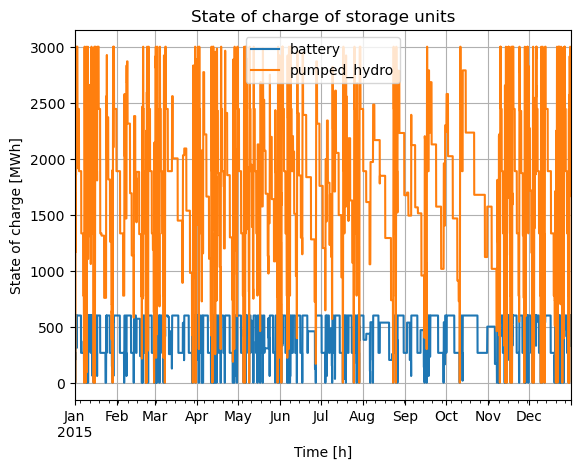

In [132]:
#plotting state of charge of storage units
network.storage_units_t.state_of_charge.plot()
plt.title('State of charge of storage units')
plt.xlabel('Time [h]')
plt.ylabel('State of charge [MWh]')
plt.legend(network.storage_units.index, loc='best')
plt.grid(True)
plt.show()

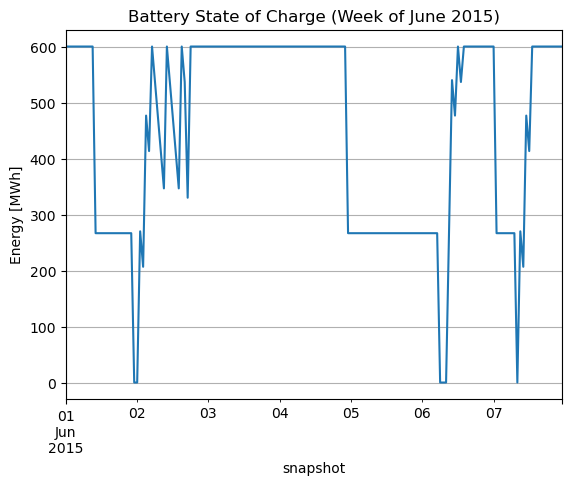

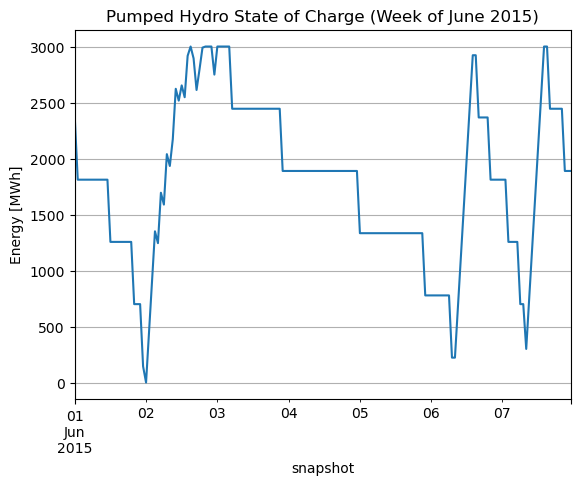

In [133]:
network.storage_units_t.state_of_charge["battery"].loc["2015-06-01":"2015-06-07"].plot()
plt.title("Battery State of Charge (Week of June 2015)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()

network.storage_units_t.state_of_charge["pumped_hydro"].loc["2015-06-01":"2015-06-07"].plot()
plt.title("Pumped Hydro State of Charge (Week of June 2015)")
plt.ylabel("Energy [MWh]")
plt.grid()
plt.show()

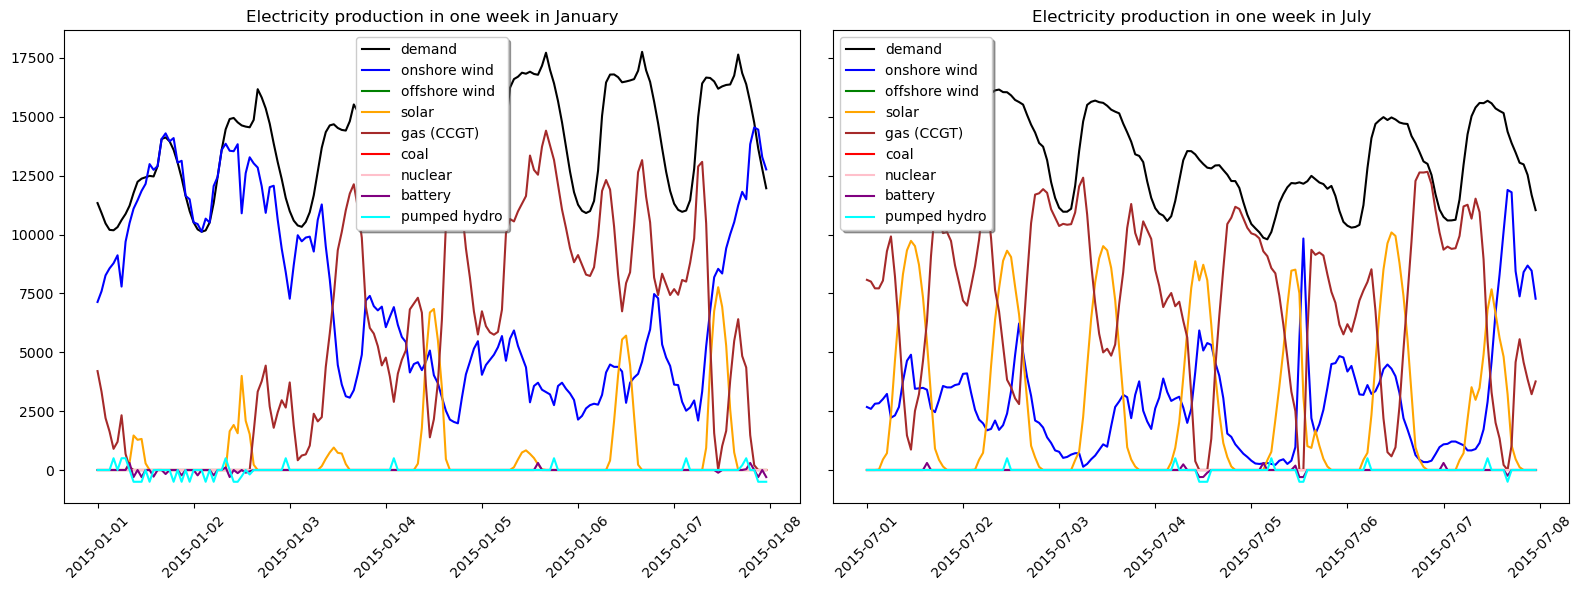

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='blue', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='green', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['CCGT'][0:168], color='brown', label='gas (CCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='red', label='coal')
axes[0].plot(network.generators_t.p['nuclear'][0:168], color='pink', label='nuclear')
axes[0].plot(network.storage_units_t.p['battery'][0:168], color='purple', label='battery')
axes[0].plot(network.storage_units_t.p['pumped_hydro'][0:168], color='cyan', label='pumped hydro')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='blue', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='green', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['CCGT'][4344:4512], color='brown', label='gas (CCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='red', label='coal')
axes[1].plot(network.generators_t.p['nuclear'][4344:4512], color='pink', label='nuclear')
axes[1].plot(network.storage_units_t.p['battery'][4344:4512], color='purple', label='battery')
axes[1].plot(network.storage_units_t.p['pumped_hydro'][4344:4512], color='cyan', label='pumped hydro')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()